In [1]:
from google.colab import drive
drive.mount('/content/drive')

zip_path_train = 'drive/My Drive/Project/Human Action Recognition/Train/train.zip'
zip_path_test  = 'drive/My Drive/Project/Human Action Recognition/Train/test.zip'

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

with ZipFile(zip_path_train, 'r') as zipObj:
    zipObj.extractall('train')

with ZipFile(zip_path_test, 'r') as zipObj:
    zipObj.extractall('test')

In [3]:
!pip uninstall jax

Found existing installation: jax 0.4.8
Uninstalling jax-0.4.8:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/jax-0.4.8.dist-info/*
    /usr/local/lib/python3.10/dist-packages/jax/*
Proceed (Y/n)? Y
  Successfully uninstalled jax-0.4.8


In [4]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.7 MB/s eta 0:00:00


In [17]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import plotly.express as px
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.metrics import accuracy_score
import glob
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [6]:
train_fol = glob.glob("/content/train/train/*") 
test_fol = glob.glob("/content/test/test/*")

In [7]:
train_csv = pd.read_csv("drive/My Drive/Project/Human Action Recognition/Training_set.csv")
test_csv = pd.read_csv("drive/My Drive/Project/Human Action Recognition/Testing_set.csv")

In [8]:
train_csv.head(5)

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [9]:
filename = train_csv['filename']
label = train_csv['label']

In [13]:
# Displaying a random sample image from the Train dataset
def disp():
    num = random.randint(1,5000)
    imgg = "Image_{}.jpg".format(num)
    train = "/content/train/train/"
    if os.path.exists(train+imgg):
        print(train+imgg)
        testImage = matplotlib.pyplot.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_csv.loc[train_csv['filename'] == "{}".format(imgg), 'label'].item()))
    else:        
        print("File Path not found \nSkipping the file!!")

/content/train/train/Image_3465.jpg


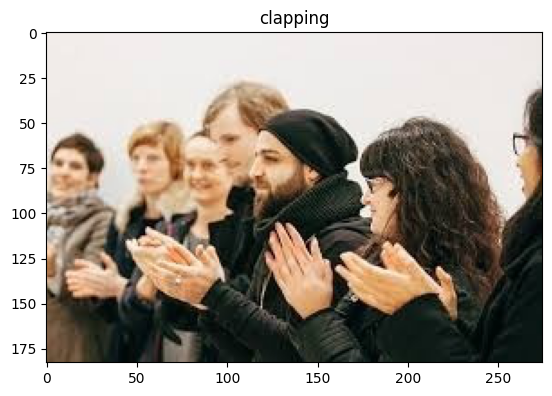

In [14]:
disp()

In [15]:
# Loading the image and converting it to numpy array of size(160,160)

img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = '/content/train/train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(label[i])

In [16]:
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [18]:
# The training labels are label encoded
y_train = to_categorical(np.asarray(train_csv['label'].factorize()[0]))

In [19]:
# Test and train split

x_train, x_test, y_train, y_test = train_test_split(iii, y_train, test_size=0.2)

In [20]:
# Load the pre-trained VGG19 model with imagenet weights
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(160,160,3),
                   pooling='max',classes=15,
                   weights='imagenet')

# Freeze the layers in the base model
for layer in pretrained_model.layers[:-3]:
        layer.trainable=False

# Add new classification layers on top of the base model
vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 20,294,735
Trainable params: 2,630,159
Non-trainable params: 17,664,576
_________________________________________________________________


In [21]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True)

# Create training and validation generators
train_generator = datagen.flow(x_train, y_train, batch_size=32, subset='training')
val_generator = datagen.flow(x_train, y_train, batch_size=32, subset='validation')
test_generator = datagen.flow(x_test, y_test, batch_size=32)

# Train the model in batches using the generators
history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tl_checkpoint_1, early_stop, reduce_lr],
    verbose=1)

<ipython-input-21-1217f2eda484>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_model.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/60
252/252 [==============================] - ETA: 0s - loss: 6.7957 - accuracy: 0.3235
Epoch 1: val_loss improved from inf to 2.29879, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 73s 236ms/step - loss: 6.7957 - accuracy: 0.3235 - val_loss: 2.2988 - val_accuracy: 0.3686 - lr: 0.0010
Epoch 2/60
252/252 [==============================] - ETA: 0s - loss: 1.8736 - accuracy: 0.4492
Epoch 2: val_loss improved from 2.29879 to 1.71719, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 55s 219ms/step - loss: 1.8736 - accuracy: 0.4492 - val_loss: 1.7172 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/60
252/252 [==============================] - ETA: 0s - loss: 1.6139 - accuracy: 0.5131
Epoch 3: val_loss improved from 1.71719 to 1.52768, saving model to tl_model_v1.weights.best.hdf5
252/252 [==============================] - 57s 224ms/step - loss: 1.6139 - accuracy: 0.5131 - val_loss: 1.5277 - val_accuracy: 0

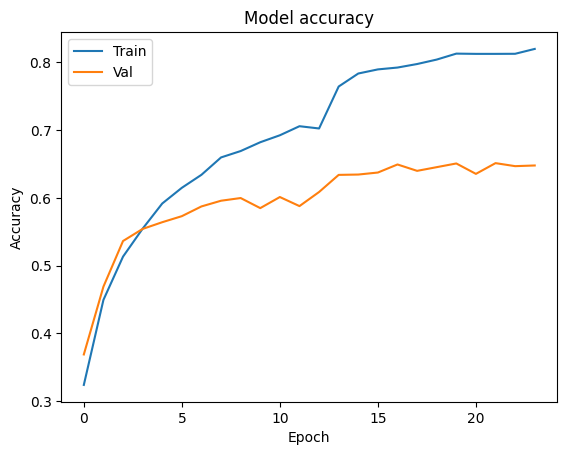

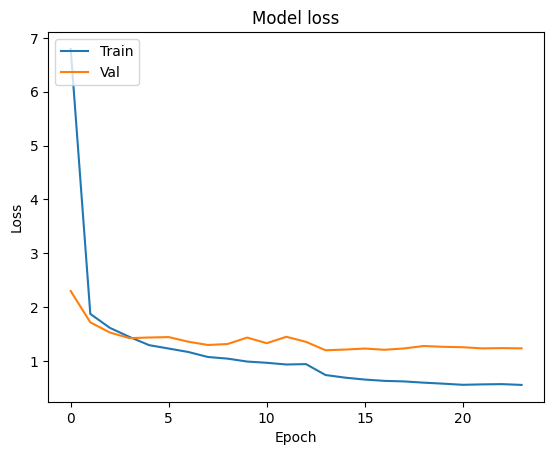

In [22]:
# Get the training and validation accuracy and loss values from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy values
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss values
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
true_classes = np.array([])
for i in range(len(test_generator)):
    batch = test_generator[i]
    labels = batch[1]
    true_classes = np.concatenate((true_classes, np.argmax(labels, axis=1)))

vgg_preds = vgg_model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))
print("Classification Report:\n")
print(classification_report(true_classes, vgg_pred_classes))

79/79 [==============================] - 15s 193ms/step
VGG16 Model Accuracy with Fine-Tuning: 62.74%
Classification Report:

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48       176
         1.0       0.53      0.59      0.56       158
         2.0       0.63      0.74      0.68       151
         3.0       0.69      0.74      0.71       172
         4.0       0.66      0.61      0.63       171
         5.0       0.61      0.56      0.59       176
         6.0       0.61      0.61      0.61       163
         7.0       0.93      0.87      0.90       172
         8.0       0.43      0.47      0.45       157
         9.0       0.62      0.69      0.65       154
        10.0       0.83      0.82      0.82       169
        11.0       0.66      0.63      0.65       174
        12.0       0.45      0.46      0.46       165
        13.0       0.74      0.74      0.74       196
        14.0       0.46      0.39      0.42       166

    accu

[[ 80  24  13  11   2  12   3   3   4   2   4   4   4   2   8]
 [ 13  94   2   7   3   2   0   0  14   5   1   0   6   1  10]
 [  2   1 111   4   2   5   1   1   5   4   1   1   6   2   5]
 [  8   4   6 127   4   2   2   0   3   6   1   4   2   0   3]
 [  1   6   4   8 104   5   1   0  14   4   1   2   9   1  11]
 [ 12   4   5   2   3  99   8   1   5  13  10   2  11   1   0]
 [  4   1   2   2   0   5 100   2   4   1   1  17   8  15   1]
 [  2   0   0   0   0   0   3 150   0   0   1   3   2   9   2]
 [  8  13   6   2   6   3   3   0  74  10   1   0  17   0  14]
 [  2   2   7   1  11   4   1   0   8 107   4   0   6   0   1]
 [  6   4   0   1   3  11   0   0   0   2 138   0   1   1   2]
 [  5   0   4   4   0   6  21   2   2   1   1 110   1  16   1]
 [  4   9   6   6   6   3   2   0  21  13   0   0  76   2  17]
 [  3   0   3   0   2   2  16   1   1   0   0  19   2 146   1]
 [  5  17   7   9  12   3   2   1  16   5   2   4  18   0  65]]


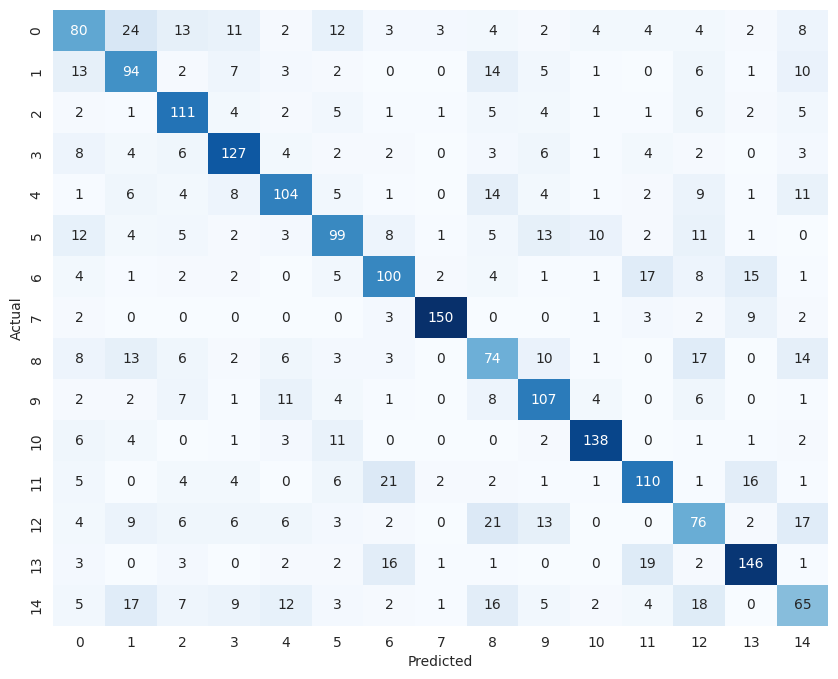

Area Under the ROC Curve: 0.9380346737040276


In [24]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
print(cm)
# Plot confusion matrix
sns.set_style('white')
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_classes, vgg_preds, multi_class='ovr')
print("Area Under the ROC Curve:", roc_auc)

In [25]:
# Create lists to store true positives, false positives, true negatives, and false negatives for each class
tp_list = []
fp_list = []
tn_list = []
fn_list = []

# Loop through each class
for i in range(cm.shape[0]):
    # Calculate true positives
    tp = cm[i,i]
    # Calculate false positives
    fp = np.sum(cm[:,i]) - tp
    # Calculate true negatives
    tn = np.sum(cm) - tp - fp - np.sum(cm[i,:])
    # Calculate false negatives
    fn = np.sum(cm[i,:]) - tp
    # Append values to lists
    tp_list.append(tp)
    fp_list.append(fp)
    tn_list.append(tn)
    fn_list.append(fn)

# Calculate true positive rate (TPR) and false positive rate (FPR) for each class
tpr_list = np.array(tp_list) / (np.array(tp_list) + np.array(fn_list))
fpr_list = np.array(fp_list) / (np.array(fp_list) + np.array(tn_list))

for i in range(0,15):
  print("TPR of class:"+str(i)+" is "+str(tpr_list[i]))

for i in range(0,15):
  print("FPR of class:"+str(i)+" is "+str(fpr_list[i]))

TPR of class:0 is 0.45454545454545453
TPR of class:1 is 0.5949367088607594
TPR of class:2 is 0.7350993377483444
TPR of class:3 is 0.7383720930232558
TPR of class:4 is 0.6081871345029239
TPR of class:5 is 0.5625
TPR of class:6 is 0.6134969325153374
TPR of class:7 is 0.872093023255814
TPR of class:8 is 0.4713375796178344
TPR of class:9 is 0.6948051948051948
TPR of class:10 is 0.8165680473372781
TPR of class:11 is 0.632183908045977
TPR of class:12 is 0.46060606060606063
TPR of class:13 is 0.7448979591836735
TPR of class:14 is 0.39156626506024095
FPR of class:0 is 0.03312720848056537
FPR of class:1 is 0.03747795414462081
FPR of class:2 is 0.02878653675819309
FPR of class:3 is 0.025664115263394866
FPR of class:4 is 0.024053452115812918
FPR of class:5 is 0.028062360801781736
FPR of class:6 is 0.027913159060700046
FPR of class:7 is 0.005004549590536852
FPR of class:8 is 0.04237658366098733
FPR of class:9 is 0.029216467463479414
FPR of class:10 is 0.012652507907817443
FPR of class:11 is 0.0250